In [1]:
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
from astropy.cosmology import WMAP9 as cosmo
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit, brentq
from fitting import get_phi_pd17
import fitting
from tqdm import tqdm

In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k1.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]
# Calculate the fraction of data that remains
fraction_remaining = len(k_gg) / len(k['k_gg'])
print(f"Fraction of data that remained: {fraction_remaining:.2f}")

Fraction of data that remained: 1.00


In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]
d_desi = Planck18.distmod(z_desi).value

In [4]:
bad_tid = 39627637697547336

# Create mask to exclude the target
mask_good = TARGETID != bad_tid

# Apply to all arrays
TARGETID = TARGETID[mask_good]
apr_mag_r = apr_mag_r[mask_good]
apr_mag_r_err = apr_mag_r_err[mask_good]
z_desi = z_desi[mask_good]
k_rr = k_rr[mask_good]

In [5]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [6]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.6)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

In [7]:
def comoving_volume(z1,z2):
    """
    Calculate the comoving volume between two redshifts.
    
    Args:
        z1 (float): Lower redshift bound
        z2 (float): Upper redshift bound
    
    Returns:
        float: Comoving volume in cubic megaparsecs (Mpc^3)
    """
    #d1 = cosmo.comoving_distance(z1).value# Mpc
    #d2 = cosmo.comoving_distance(z2).value# Mpc
    return Planck18.comoving_volume(z2).value-Planck18.comoving_volume(z1).value

In [8]:
def get_phis(Ls, z, 
             a_alpha, b_alpha, 
             a_beta, b_beta,
             aP, bP, cP,
             aL, bL, cL):
    """
    Evaluate the QLF at luminosities Ls and redshift z using evolving parameters.
    """
    # Redshift-evolving slopes
    alpha = a_alpha * (z-2.45) + b_alpha
    beta = a_beta * (z-2.45) + b_beta

    # Convert to gamma slopes
    gamma1 = -alpha - 1
    gamma2 = -beta - 1

    # Redshift-evolving L_star and phi_star
    log10_L_star = aL *(z-2.45)**2 + bL * (z-2.45) + cL
    log10_phi_star = aP * (z-2.45)**2 + bP * (z-2.45) + cP

    L_star = 10 ** log10_L_star
    phi_star = 10 ** log10_phi_star

    # Evaluate QLF
    phis = phi_star / ((Ls / L_star) ** gamma1 + (Ls / L_star) ** gamma2)
    return phis


Evaluating bins: 100%|██████████| 5/5 [00:00<00:00, 104.60it/s]


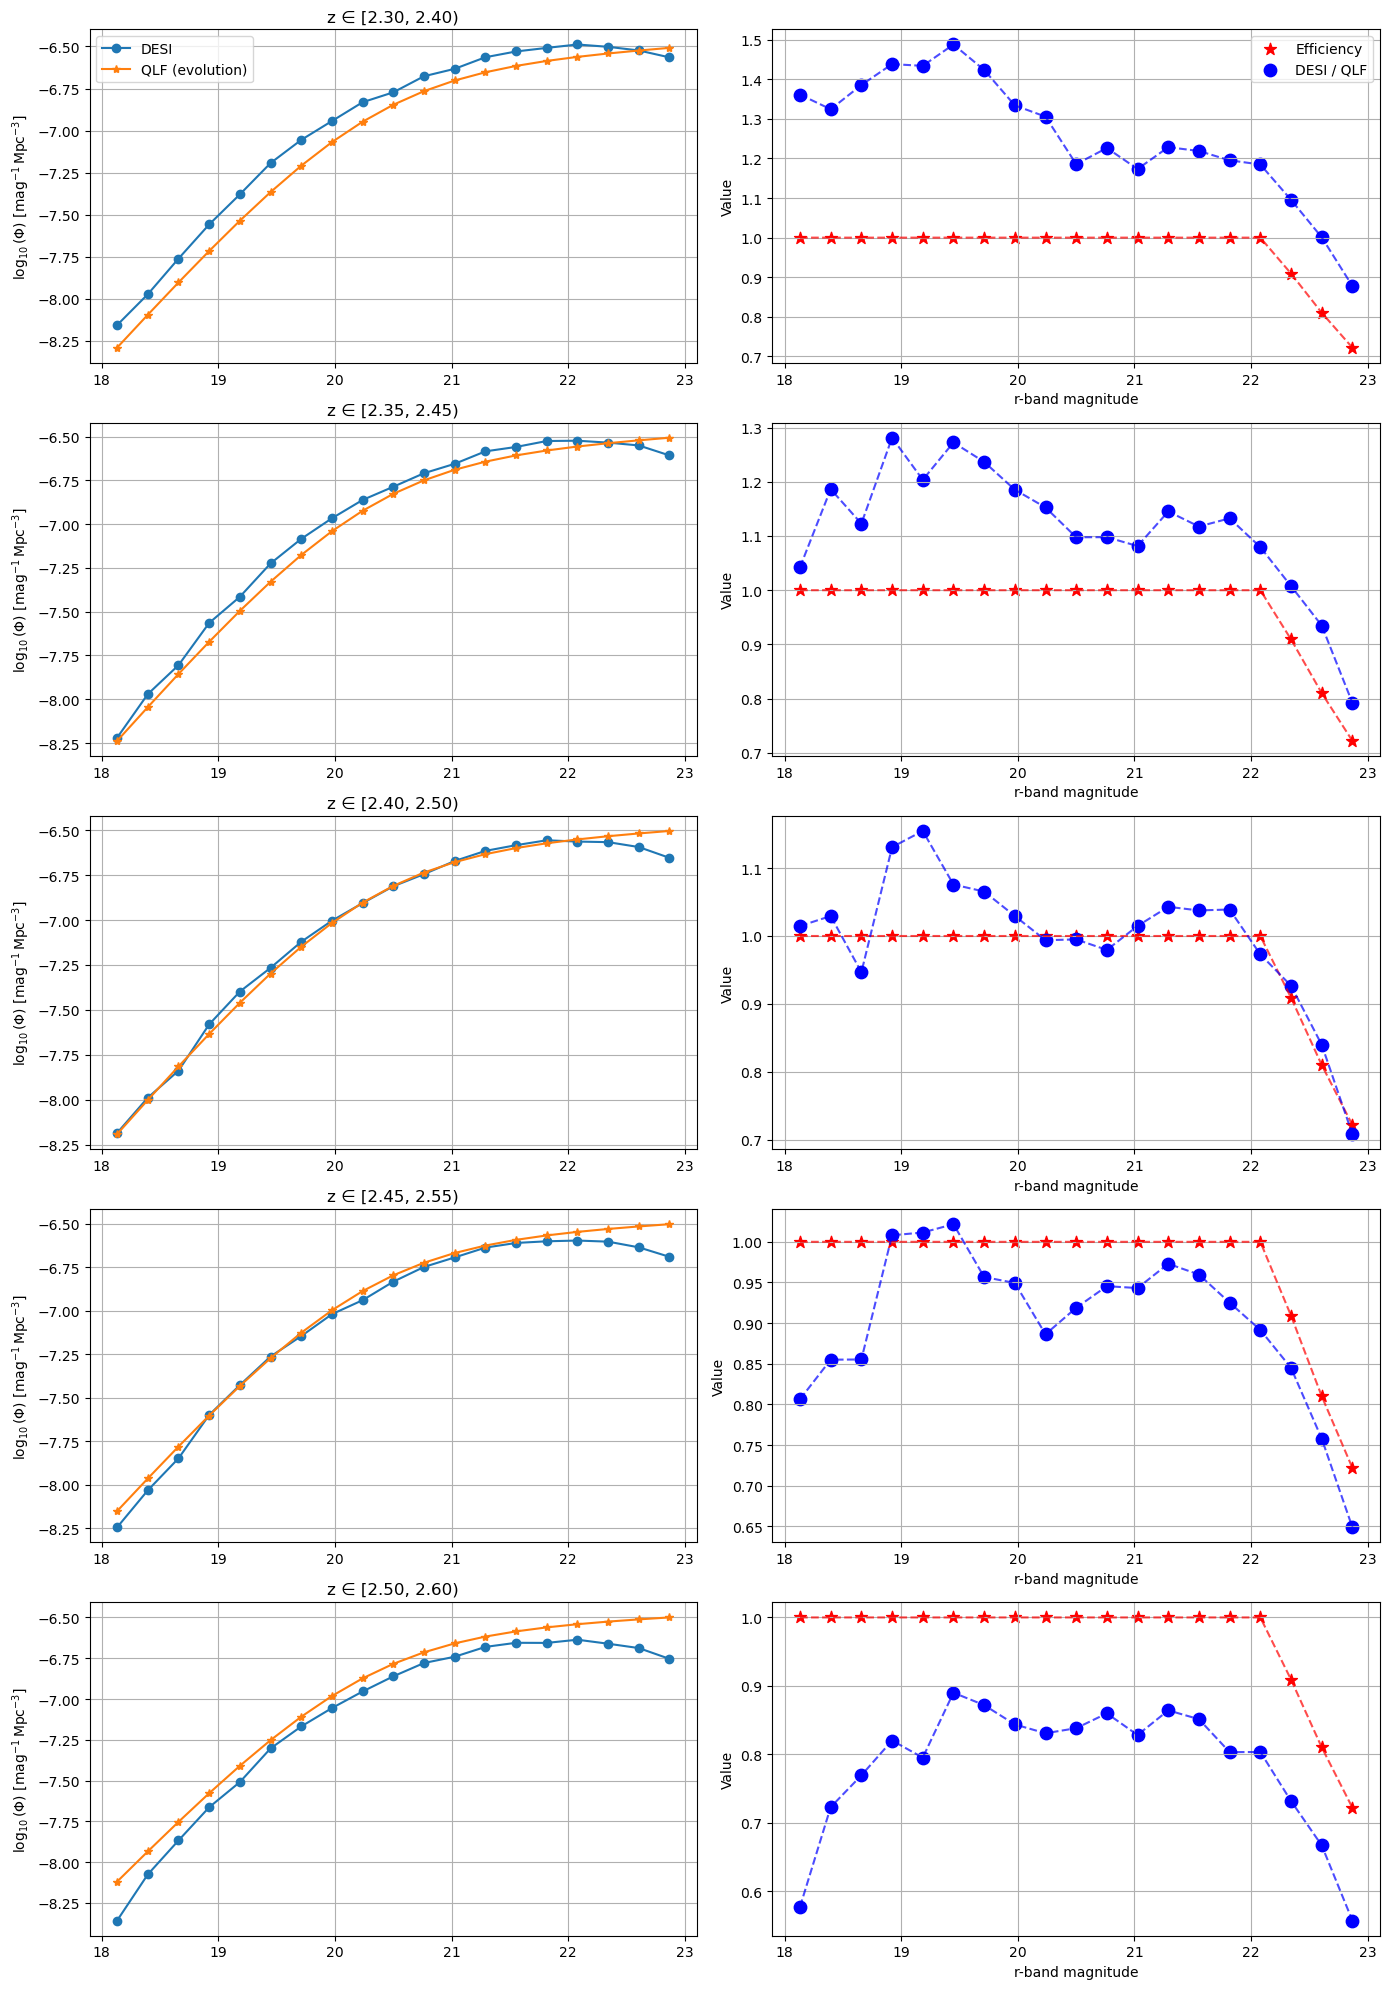

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define efficiency function
def eff(m, b, m0):
    return np.where(m < m0, 1, 10**(-b * (m - m0) / 2.5))

samples = np.load("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples_evolution.npz")

# Extract median parameter values
m0_median = np.median(samples['m0'])
b_median = np.median(samples['b'])

aL, bL, cL = np.median(samples['aL']), np.median(samples['bL']), np.median(samples['cL'])
aP, bP, cP = np.median(samples['aP']), np.median(samples['bP']), np.median(samples['cP'])
a_alpha, b_alpha = np.median(samples['a_alpha']), np.median(samples['b_alpha'])
a_beta, b_beta = np.median(samples['a_beta']), np.median(samples['b_beta'])

# Redshift bins and magnitude bins
# ------------------------
zeffs = [2.35, 2.4,2.45,2.5,2.55]
dz = 0.1
mag_r_bins = np.linspace(np.min(apr_mag_r), np.max(apr_mag_r), 20)
mag_r_centers = 0.5 * (mag_r_bins[:-1] + mag_r_bins[1:])
mag_r_bin_width = mag_r_bins[1] - mag_r_bins[0]

# ------------------------
# Plotting
# ------------------------
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))
axes = axes.reshape(5, 2)

for i, z_eff in enumerate(tqdm(zeffs, desc="Evaluating bins")):
    zmin, zmax = z_eff - dz / 2, z_eff + dz / 2

    # Apply mask
    mask = (z_desi > zmin) & (z_desi <= zmax)
    apr_mag_r_bin = apr_mag_r[mask]
    d_bin = d_desi[mask]
    k_rr_bin = k_rr[mask]

    if len(apr_mag_r_bin) == 0:
        axes[i, 0].set_title(f"No data in z ∈ [{zmin}, {zmax})")
        axes[i, 1].axis('off')
        continue

    # DESI QLF
    counts_r, _ = np.histogram(apr_mag_r_bin, bins=mag_r_bins)
    phi_desi = counts_r / comoving_volume(zmin, zmax) / mag_r_bin_width

    # Model QLF
    abs_mag = mag_r_centers - np.mean(k_rr_bin) - np.mean(d_bin)
    L = abs_mag_to_L(abs_mag)
    phi_model = 0.4*get_phis(
        Ls=L, z=z_eff,
        a_alpha=a_alpha, b_alpha=b_alpha,
        a_beta=a_beta, b_beta=b_beta,
        aP=aP, bP=bP, cP=cP,
        aL=aL, bL=bL, cL=cL
    )

    # Efficiency and ratio
    efficiency = eff(mag_r_centers, b_median, m0_median)
    ratio = phi_desi / phi_model

    # --- Upper panel: DESI vs QLF ---
    ax0 = axes[i, 0]
    ax0.plot(mag_r_centers, np.log10(phi_desi), label='DESI', marker='o')
    ax0.plot(mag_r_centers, np.log10(phi_model), label='QLF (evolution)', marker='*', linewidth=1.5)
    ax0.set_title(f'z ∈ [{zmin:.2f}, {zmax:.2f})')
    ax0.set_ylabel(r'$\log_{10}(\Phi)\ [\mathrm{mag}^{-1}\,\mathrm{Mpc}^{-3}]$')
    ax0.grid(True)
    if i == 0:
        ax0.legend()

    # --- Lower panel: Efficiency vs Ratio ---
    ax1 = axes[i, 1]
    ax1.scatter(mag_r_centers, efficiency, color='red', marker='*', s=80, label='Efficiency')
    ax1.scatter(mag_r_centers, ratio, color='blue', marker='o', s=80, label='DESI / QLF')
    ax1.plot(mag_r_centers, efficiency, color='red', linestyle='--', alpha=0.7)
    ax1.plot(mag_r_centers, ratio, color='blue', linestyle='--', alpha=0.7)
    ax1.set_ylabel('Value')
    ax1.set_xlabel('r-band magnitude')
    ax1.grid(True)
    if i == 0:
        ax1.legend()

plt.tight_layout()
plt.show()